In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO,ffs,importstuff
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
from tools.validation import r2_analysis
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
#import feature_select
#from dask.distributed import Client
#client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_524/1262857276.py:25: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def train_with_FFS(filepath=None,case='Maria',TYPE='3D' or '2D',suffix=None,trainXy=None,validXy=None,LT=24,readDATA=True,twostep=False,findextra=30,subsetstart=-5,overwriteholdmem=None):
    if case=='Maria':
        filepath = filepath#input('Enter Path:')
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Import Preprocessed Flat Data and PCA dictionary
        #------------------------------------------------------------------------------------------------------------------------------------------
        if readDATA is True:
            if TYPE=='3D':
                tempdict = {}
                for varname in ['u','v','w','qv','theta','heatsum','hdia','rad','ir']:
                    temp = [read_and_proc.depickle(filepath+str(lime)+suffix)[varname] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
                    tempdict[varname] = maria_IO.long_MariaExps(temp)[0]
            elif TYPE=='2D':
                tempdict = {}
                for varname in ['u','v','w','qv','theta','heatsum','hdia','rad','ir']:
                    temp = [read_and_proc.depickle(filepath+str(lime)+suffix)[varname] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
                    tempdict[varname] = maria_IO.long_MariaExps(maria_IO.to_azim(temp))[0]            
                    #------------------------------------------------------------------------------------------------------------------------------------------
                    # Save to xarray
                    #------------------------------------------------------------------------------------------------------------------------------------------
                    dims = ['sample','flatarray']
                    coords = dict(sample=np.linspace(0,tempdict['u'].shape[0]-1,tempdict['u'].shape[0]),flatarray=np.linspace(0,tempdict['u'].shape[1]-1,tempdict['u'].shape[1]))
                    ds = xr.Dataset(coords=coords)
            maria_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','heatsum','hdia','rad','qv','ir'],\
                                                             varfile=[tempdict['u'],tempdict['v'],tempdict['w'],tempdict['theta'],tempdict['heatsum'],tempdict['hdia'],tempdict['rad'],tempdict['qv'],tempdict['ir']],dims=dims,coords=coords)
            del tempdict
            gc.collect()
        else: print('pass')
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Import PCA dictionary
        #------------------------------------------------------------------------------------------------------------------------------------------
        if TYPE=='3D':
            folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/'
            dict1 = read_and_proc.depickle(folderpath+'PCA/PCAdict2')
        elif TYPE=='2D':
            folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/intermediate/'
            dict1 = read_and_proc.depickle(folderpath+'PCA/PCAdict')
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Import Input/output datasets
        #------------------------------------------------------------------------------------------------------------------------------------------
        if TYPE=='3D':
            nummem=[54,26,50,5,75,12,12,10,10]
            folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/'
            nummemOUT = [54,80,50,75]
            holdmem = [int(obj) for obj in np.linspace(222,232-1,10)]
        elif TYPE=='2D':
            nummem = [20,11,20,5,12,7,7,5,5]
            folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/intermediate/'
            nummemOUT = [20,11,20,12]
            holdmem = [int(obj) for obj in np.linspace(75,80-1,5)]
        Xtrain = trainXy[0]#read_and_proc.depickle(folderpath+'inputoutput/Xtrain_fullexp')
        Xvalid = validXy[0]#read_and_proc.depickle(folderpath+'inputoutput/Xvalid_fullexp')
        ytrain = trainXy[1]#read_and_proc.depickle(folderpath+'inputoutput/ytrain_fullexp')
        yvalid = validXy[1]#read_and_proc.depickle(folderpath+'inputoutput/yvalid_fullexp')
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Filter non-RAD inputs and fit linear regression model
        #------------------------------------------------------------------------------------------------------------------------------------------
        ##for trainobj,validobj in zip(ytrain,yvalid):    yall.append([trainobj,validobj])
        print("===Start FFW and fit LinearRegression Model==")
        #print(overwriteholdmem)
        if readDATA is True:
            model_FFW,reducedX_FFW,newfeature_FFW = ffs.random_FFT(None,None,4,LT).do_seq_FS_maria(data=maria_data,yall=[ytrain,yvalid],Xtrain=Xtrain,Xvalid=Xvalid,findextra=findextra,cv=7,nummem=nummemOUT,
                                                                                                   holdmem=holdmem,optimizeto='valid')
            return maria_data, dict1, [Xtrain,Xvalid], [ytrain,yvalid], {'model':model_FFW,'reducedX':reducedX_FFW,'newfeature':newfeature_FFW}
        else:
            if twostep is True: 
                subsetTRAIN,subsetVALID = Xtrain[:,subsetstart:], Xvalid[:,subsetstart:]
                model_FFW,reducedX_FFW,newfeature_FFW = ffs.random_FFT(None,None,4,LT).do_seq_FS_maria(data=None,yall=[ytrain,yvalid],Xtrain=subsetTRAIN,Xvalid=subsetVALID,findextra=findextra,cv=7,nummem=nummemOUT,holdmem=[overwriteholdmem],
                                                                                                       optimizeto='valid')
                return [Xtrain,Xvalid], [ytrain,yvalid], {'model':model_FFW,'reducedX':reducedX_FFW,'newfeature':newfeature_FFW}
            else:
                if overwriteholdmem:
                    #print([overwriteholdmem])
                    model_FFW,reducedX_FFW,newfeature_FFW = ffs.random_FFT(None,None,4,LT).do_seq_FS_maria(data=None,yall=[ytrain,yvalid],Xtrain=Xtrain,Xvalid=Xvalid,findextra=findextra,cv=7,nummem=nummemOUT,
                                                                                                           holdmem=overwriteholdmem,optimizeto='valid')
                    return dict1, [Xtrain,Xvalid], [ytrain,yvalid], {'model':model_FFW,'reducedX':reducedX_FFW,'newfeature':newfeature_FFW}
                else:
                    model_FFW,reducedX_FFW,newfeature_FFW = ffs.random_FFT(None,None,4,LT).do_seq_FS_maria(data=None,yall=[ytrain,yvalid],Xtrain=Xtrain,Xvalid=Xvalid,findextra=findextra,cv=7,nummem=nummemOUT,holdmem=holdmem,optimizeto='valid')
                    return dict1, [Xtrain,Xvalid], [ytrain,yvalid], {'model':model_FFW,'reducedX':reducedX_FFW,'newfeature':newfeature_FFW}            

### Xy

In [3]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
enter = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'

maria_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['u'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
divider = np.asarray([maria_u[0][12:].shape[0],maria_u[1][36:].shape[0],maria_u[2][60:].shape[0],maria_u[3][96:].shape[0],maria_u[4][36:].shape[0]]).cumsum()

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
! ls /work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/intermediate/inputoutput/

6	      Xtrain_test4  Xvalid_test4  ytrain_test2	yvalid_test2
Xtrain_test1  Xvalid_test1  radterms	  ytrain_test3	yvalid_test3
Xtrain_test2  Xvalid_test2  stdterms	  ytrain_test4	yvalid_test4
Xtrain_test3  Xvalid_test3  ytrain_test1  yvalid_test1


In [4]:
folder = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/'#intermediate/'
exp = 1
store = [read_and_proc.depickle(obj) for obj in sorted(glob.glob(folder+'inputoutput/6/*test'+str(exp)))]
trainstore,validstore = [store[0],store[2]],[store[1],store[3]]

In [60]:
#maria_data, dict1, Xdict, ydict, FFSoutput = train_with_FFS('Maria','2D','_smooth_preproc_dict1b_g',trainstore,validstore,6,False,True,-5)
hr='6'
#################################################################################################################################
# Two steps FFW
#################################################################################################################################
folder = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/intermediate/'
X,y,FFSoutput = [],[],[]
if hr=='24':
    chooserad = [[75,77,79],[77,79],[76,77,78],[75,77,78]]#[[75,77,79],[77,79],[76,77,78],[75,77,78]]
elif hr=='6':
    chooserad = [[76,78],[78,79],[75,77],[77,79]]
#################################################################################################################################
# Step I: Remove unnecessary RADs
#################################################################################################################################
#for i in range(5):
#    temp1 = train_with_FFS(enter,'Maria','2D','_smooth_preproc_dict1b_g',trainstore,validstore,6,False,True,4,-5,i) #First step
#    X.append(temp1[0])
#    y.append(temp1[1])
#    FFSoutput.append(temp1[2])
#FFS_firststep = {'model':[obj['model'] for obj in FFSoutput],'reducedX':[obj['reducedX'] for obj in FFSoutput],'newfeature':[obj['newfeature'] for obj in FFSoutput]}
#################################################################################################################################
# Step I: Add non-RADs
#################################################################################################################################
#chooserad = [[75,77,79],[77,79],[76,77,78],[75,77,78]]#[[75,77,79],[77,79],[76,77,78],[75,77,78]]
for i in tqdm(range(1,5)):
    store = [read_and_proc.depickle(obj) for obj in sorted(glob.glob(folder+'inputoutput/6/*test'+str(i)))]
    trainstore,validstore = [store[0],store[2]],[store[1],store[3]]
    _, Xout, yout, FFSout = train_with_FFS(enter,'Maria','2D','_smooth_preproc_dict1b_g',trainstore,validstore,6,False,False,30,-5,chooserad[i-1])
    X.append(Xout)
    y.append(yout)
    FFSoutput.append(FFSout)
FFS_secondstep = {'model':[obj['model'] for obj in FFSoutput],'reducedX':[obj['reducedX'] for obj in FFSoutput],'newfeature':[obj['newfeature'] for obj in FFSoutput]}

  0%|          | 0/4 [00:00<?, ?it/s]

pass
===Start FFW and fit LinearRegression Model==


  0%|          | 0/30 [00:00<?, ?it/s]

pass
===Start FFW and fit LinearRegression Model==


  0%|          | 0/30 [00:00<?, ?it/s]

pass
===Start FFW and fit LinearRegression Model==


  0%|          | 0/30 [00:00<?, ?it/s]

pass
===Start FFW and fit LinearRegression Model==


  0%|          | 0/30 [00:00<?, ?it/s]

#### r2

In [7]:
maria_data, dict1, size = importstuff.import_Pipeline_validate('Maria','2D','_smooth_preproc_dict1b_g')

Enter Path: /work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [57]:
LT=6
temp = [r2_analysis.preproc_r2(maria_data,None,None)._back_to_exp(timeseries=maria_data[varname].data,divider=list(np.asarray([obj[0] for obj in size[0]]).cumsum())) for varname in ['u','v','w','theta']]

train_realUV,test_realUV = [],[]
for i in tqdm([1,2,3,4]):#range(15)):#range(1)):
    trainobj = r2_analysis.preproc_r2(maria_data,None,None).windrates_real_maria(uvwheat=temp,LT=LT,category='train',testindex=[i])
    testobj = r2_analysis.preproc_r2(maria_data,None,None).windrates_real_maria(uvwheat=temp,LT=LT,category='test',testindex=[i])
    train_realUV.append(trainobj)
    test_realUV.append(testobj)
del trainobj,testobj
gc.collect()

  0%|          | 0/4 [00:00<?, ?it/s]

21

In [9]:
class retrieve_cartesian:
    def __init__(self,path=None,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None,case='Maria'):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        self.case=case
        self.path=path
        
    def get_time_diff_terms_intermediate(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            if self.case=='Maria':
                sizesets = [39,360,int(array[0].shape[1]/39/360)]
            elif self.case=='Haiyan':
                sizesets = [10,360,int(array[0].shape[1]/10/360)]
            store = []
            for exp in array:
                a = forward_diff(np.nanmean(exp.reshape(exp.shape[0],sizesets[0],sizesets[1],sizesets[2]),axis=2).reshape(exp.shape[0],-1),timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def windrates_real_maria(self,uvwheatpath=None,LT=None,category='train',testindex=[2,12]):
        u = [read_and_proc.depickle(self.path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+self.suffix)['u'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
        v = [read_and_proc.depickle(self.path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+self.suffix)['v'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
        w = [read_and_proc.depickle(self.path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+self.suffix)['w'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
        theta = [read_and_proc.depickle(self.path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+self.suffix)['theta'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
        
        if category=='train':
            ut = [u[i] for i in range(len(u)) if i not in testindex]
            vt = [v[i] for i in range(len(v)) if i not in testindex]
            wt = [w[i] for i in range(len(w)) if i not in testindex]
            thetat = [theta[i] for i in range(len(theta)) if i not in testindex]
            assert len(ut)==4, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms_intermediate(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms_intermediate(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])
        
        tempdict = {}
        for obj in ['u','v','w','theta']:
            tempdict[obj] = dtermsT[obj]
        del dtermsT
        gc.collect()
        return tempdict
    
    def windrates_real_haiyan(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(self.path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in (range(1,21))].copy()
        v = [read_and_proc.depickle(self.path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in (range(1,21))].copy()
        w = [read_and_proc.depickle(self.path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in (range(1,21))].copy()
        theta = [read_and_proc.depickle(self.path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in (range(1,21))].copy()
        
        if category=='train':
            popindex = validindex+testindex
            ut = [u[i] for i in range(len(u)) if i not in popindex]
            vt = [v[i] for i in range(len(v)) if i not in popindex]
            wt = [w[i] for i in range(len(w)) if i not in popindex]
            thetat = [theta[i] for i in range(len(theta)) if i not in popindex]
            assert len(ut)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms_intermediate(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms_intermediate(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms_intermediate(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt
    
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.target=='surface') or (self.target=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCA_dict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCA_dict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.target=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.target=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
        
    def output_r2(self,FFWmodels=None,reducedX=None,realU=None,realV=None,realW=None,realTH=None,case='Haiyan'):
        yf = [models.predict(Xns) for (models,Xns) in zip(FFWmodels[:],reducedX[:])]
        mlr_r2 = []
        if case=='Maria_axisym': num=30
        elif case=='1step_other': num=45
        else: num=len(yf)
        
        for i in (range(len(yf))):#len(yf))):
            if case=='Maria':
                temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,360,167])
                mlr_r2.append(r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0)))
            elif case=='Haiyan':
                temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                mlr_r2.append(a)
            elif case=='Haiyan_axisym':
                temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,208])
                a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                mlr_r2.append(a)
            elif case=='Maria_axisym':
                temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,200])
                a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                mlr_r2.append(a)
            del temp1,temp2
            gc.collect()
        return mlr_r2

In [37]:
from sklearn.metrics import r2_score
class _get_r2:
    def __init__(self,pcadict=None,afdict=None,numcomp=None,LT=None,FFWmodel=None,reducedX=None,realVARS=None,case='Haiyan_axisym',suffix=None,single=True):
        self.pcadict=pcadict
        self.afdict=afdict
        self.numcomp=numcomp
        self.lti=LT
        self.FFWmodel=FFWmodel
        self.reducedX=reducedX
        self.realvar = realVARS
        self.case = case
        self.suffix=suffix
        
    def _get_trainR2(self):
        return [retrieve_cartesian(PCA_dict=self.pcadict,Af_dict=self.afdict,numcomp=self.numcomp,LT=self.lti,forecastPC=None,target='all',\
                              suffix=self.suffix).output_r2(FFWmodels=self.FFWmodel[i],reducedX=self.reducedX[i],realU=self.realvar[i]['du'],realV=self.realvar[i]['dv'],realW=self.realvar[i]['dw'],realTH=self.realvar[i]['dth'],case=self.case)
               for i in tqdm(range(len(self.FFWmodel)))]
    
    def _get_validR2(self,X=None,y=None,locselected=[121,122,123,124],newfeature=None,selectlocloop=False):
        def _get_loopfeature(X=None,y=None,timeindx=None,lochold=None):
            if self.case=='Haiyan_axisym':
                yvalid = [yobj[1] for yobj in y[timeindx]]
                mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=self.lti,auxIN=None).transform(X[timeindx]['dtthuvwqv'],yvalid)
            elif self.case=='Maria_axisym':
                try:
                    mlrIN_v,mlrOUT_v=mlr.delete_padding(X[timeindx],y[1][timeindx])
                except:
                    mlrIN_v,mlrOUT_v=mlr.delete_padding(X[timeindx],y[timeindx])                    
            loopfeature = [np.asarray(lochold.copy())]#[np.asarray(locselected.copy())]
            for i in range(len(newfeature[timeindx])):
                loopfeature.append(np.append(loopfeature[i],newfeature[timeindx][i]))
            return loopfeature,mlrIN_v,mlrOUT_v
        r2store = []
        for i in range(len(self.FFWmodel)):
            if selectlocloop is False:
                loopfeature,mlrIN_v,_ = _get_loopfeature(X,y,i,locselected)
            else:
                loctoin = [locselected[i]]
                loopfeature,mlrIN_v,_ = _get_loopfeature(X,y,i,loctoin)
                print((loopfeature))
            reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
            r2_train = retrieve_cartesian(PCA_dict=self.pcadict,Af_dict=self.afdict,numcomp=self.numcomp,LT=self.lti,forecastPC=None,target='all',\
                                          suffix=self.suffix).output_r2(FFWmodels=self.FFWmodel[i],reducedX=reducedX_test[1:],realU=self.realvar[i]['du'],realV=self.realvar[i]['dv'],realW=self.realvar[i]['dw'],realTH=self.realvar[i]['dth'],
                                                                   case=self.case)
            r2store.append(r2_train)
        return r2store
            
    def _get_testR2(self,X=None,y=None,locselected=[121,122,123,124],newfeature=None):
        def _get_loopfeature(X=None,y=None,timeindx=None):
            yvalid = [yobj[2] for yobj in y[timeindx]]
            mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=self.lti,auxIN=None).transform(X[timeindx]['dtthuvwqv'],yvalid)
                
            loopfeature = [np.asarray(locselected.copy())]
            for i in range(len(newfeature[timeindx])):
                loopfeature.append(np.append(loopfeature[i],newfeature[timeindx][i]))
            return loopfeature,mlrIN_v,mlrOUT_v
        r2store = []
        for i in tqdm(range(len(self.FFWmodel))):
            loopfeature,mlrIN_v,_ = _get_loopfeature(X,y,i)
            reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
            r2_train = cartesian_retrieve.retrieve_cartesian(PCA_dict=self.pcadict,Af_dict=self.afdict,numcomp=self.numcomp,LT=self.lti,forecastPC=None,target='all',\
                                          suffix=self.suffix).output_r2(FFWmodels=self.FFWmodel[i],reducedX=reducedX_test[1:],realU=self.realvar[i]['du'],realV=self.realvar[i]['dv'],realW=self.realvar[i]['dw'],realTH=self.realvar[i]['dth'],
                                                                   case=self.case)
            r2store.append(r2_train)
        return r2store

In [61]:
suffix = '_smooth_preproc_dict1b_g'
#r2valid = _get_r2(pcastore,haiyan_data,[26,18,48,14],24,haiyanmodelsDICT['model'],haiyanmodelsDICT['reducedX'],valid_realUV,'Haiyan_axisym')._get_validR2(Xvalid,yall,[121,122,123,124],haiyanmodelsDICT['newfeature'])
#r2test = _get_r2(pcastore,haiyan_data,[26,18,48,14],24,haiyanmodelsDICT['model'],haiyanmodelsDICT['reducedX'],test_realUV,'Haiyan_axisym')._get_testR2(Xtest,yall,[121,122,123,124],haiyanmodelsDICT['newfeature'
################################################################################################################################################################################################################################
# First FFS sttep
#r2test = _get_r2(dict1,maria_data,[20,11,20,12],LT,FFS_firststep['model'],FFS_firststep['reducedX'],[test_realUV[3] for i in range(5)],'Maria_axisym')._get_validR2([X[0][1] for i in range(5)],[y[0][1] for i in range(5)],\
#[75,76,77,78,79],FFS_firststep['newfeature'],True)
#r2train = _get_r2(dict1,maria_data,[20,11,20,12],LT,FFS_firststep['model'],FFS_firststep['reducedX'],[train_realUV[3] for i in range(5)],'Maria_axisym')._get_trainR2()
################################################################################################################################################################################################################################
# Second FFS sttep
# First test: Optimal [[75,77,79],[77,79],[76,77,78],[75,77,78]]

#r2test = _get_r2(dict1,maria_data,[20,11,20,12],6,FFS_secondstep['model'],FFS_secondstep['reducedX'],test_realUV,'Maria_axisym')._get_validR2([obj[0] for obj in X],[obj[0] for obj in y],\
#[[76,78],[78,79],[75,77],[77,79]],FFS_secondstep['newfeature'],True)
r2train = _get_r2(dict1,maria_data,[20,11,20,12],6,FFS_secondstep['model'],FFS_secondstep['reducedX'],train_realUV,'Maria_axisym')._get_trainR2()

  0%|          | 0/4 [00:00<?, ?it/s]

#### First FFS

In [35]:
FFS_firststep['newfeature']

[[4, 2, 1, 3], [4, 2, 0, 3], [4, 0, 1, 3], [4, 2, 0, 1], [2, 0, 1, 3]]

/tmp/ipykernel_2704390/2844531993.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


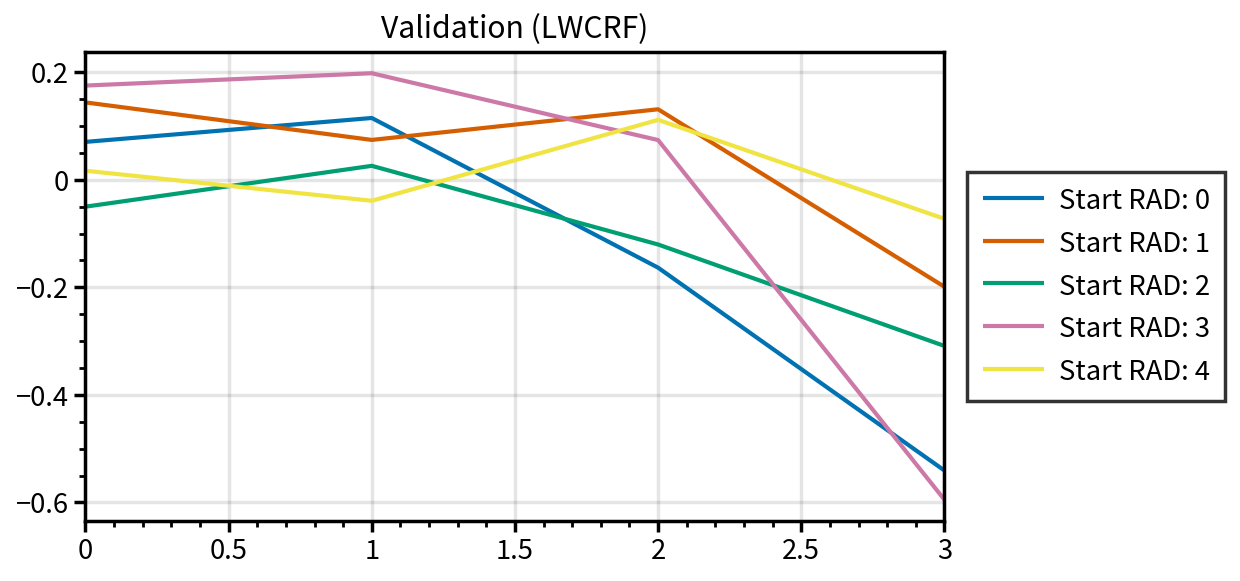

In [108]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

import matplotlib.pyplot as plt
colors=plt.cm.tab10(np.linspace(0, 1, 10))
fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(5):
    axs.plot(r2test[i],label=f'Start RAD: {i}')
axs.legend(loc='r',ncols=1)
axs.format(title='Validation (LWCRF)')
plt.savefig('SFS1_valid_LWCRF.png',dpi=400)
plt.show()

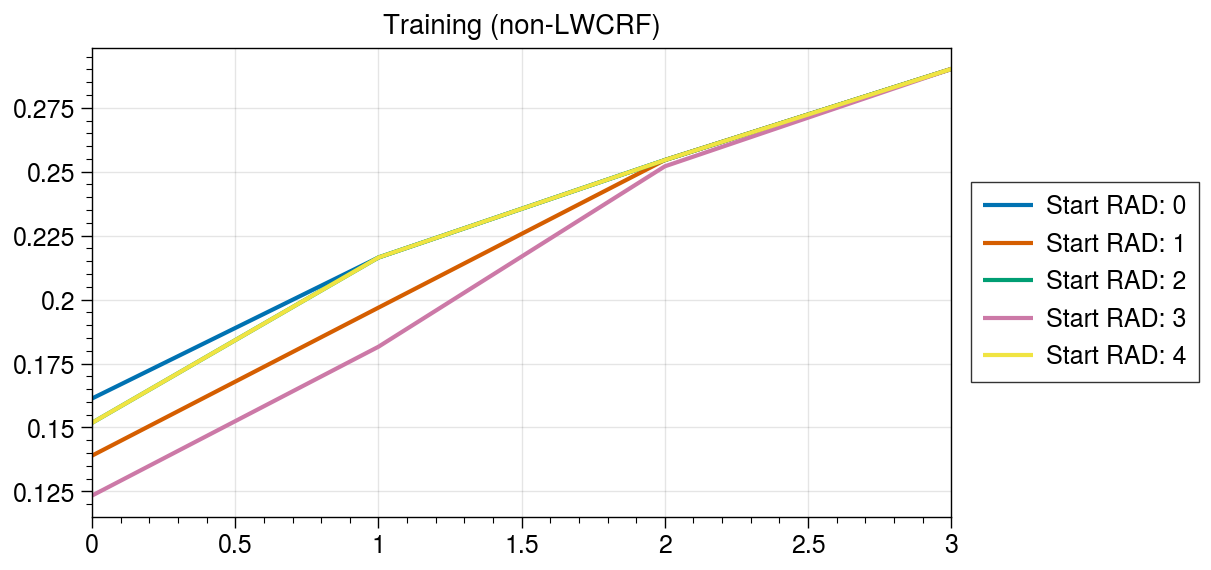

In [36]:
fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(5):
    axs.plot(r2train[i],label=f'Start RAD: {i}')
axs.legend(loc='r',ncols=1)
axs.format(title='Training (non-LWCRF)')
#plt.savefig('SFS1_train_lwcrf.png',dpi=400)
plt.show()

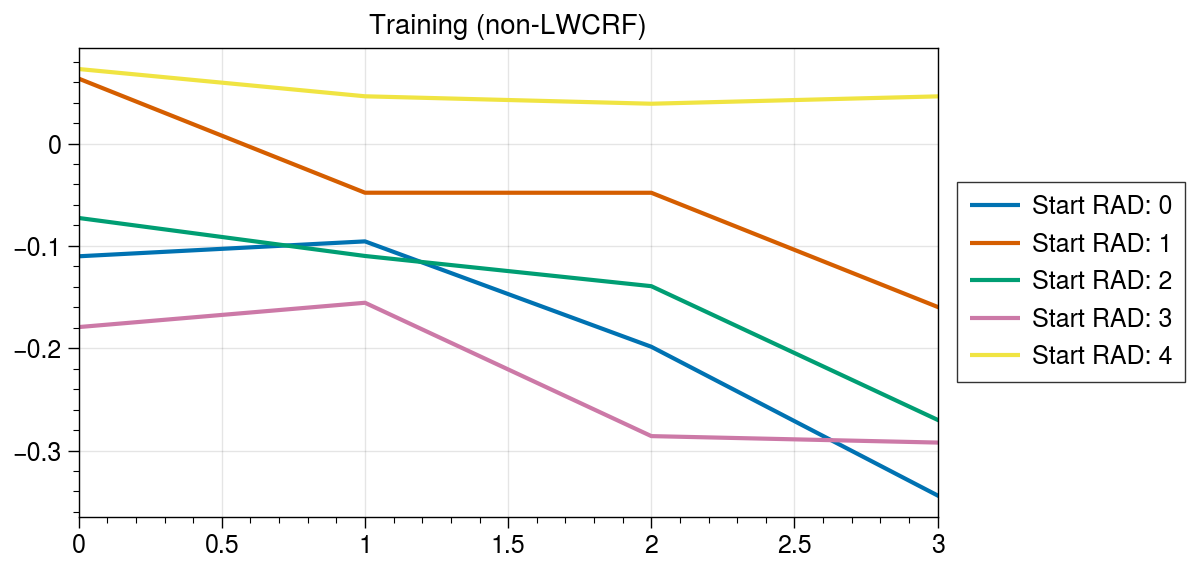

In [37]:
fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(5):
    axs.plot(r2test[i],label=f'Start RAD: {i}')
axs.legend(loc='r',ncols=1)
axs.format(title='Training (non-LWCRF)')
#plt.savefig('SFS1_train_lwcrf.png',dpi=400)
plt.show()

#### Second FFS

/tmp/ipykernel_2722508/4175830521.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


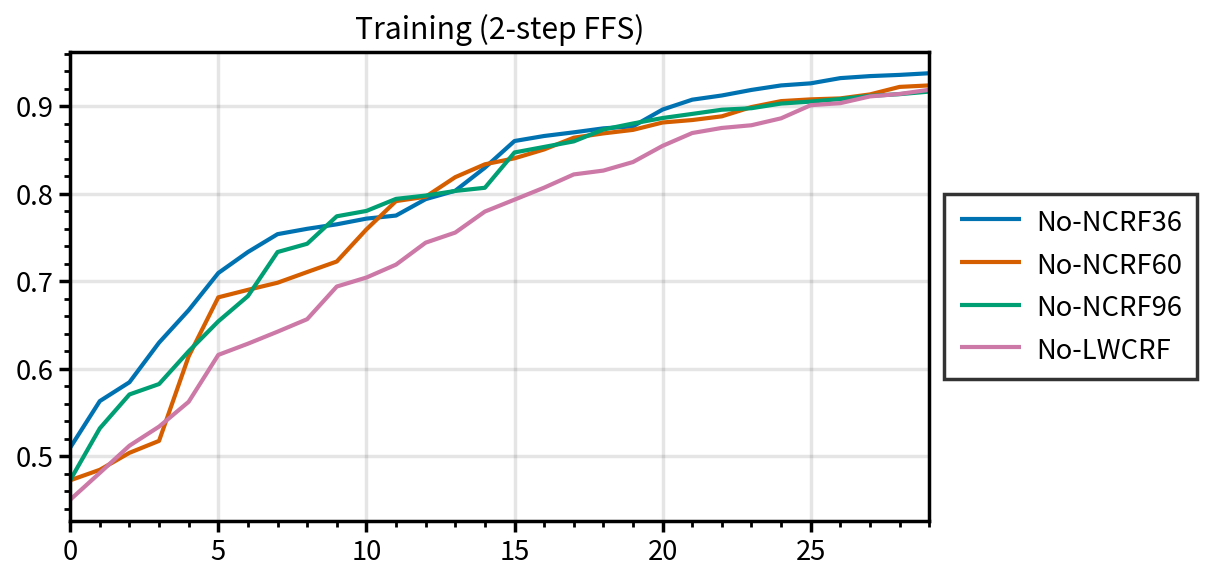

In [39]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

labels=['No-NCRF36','No-NCRF60','No-NCRF96','No-LWCRF']
import matplotlib.pyplot as plt
colors=plt.cm.tab10(np.linspace(0, 1, 10))
fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(4):
    axs.plot(r2train[i],label=labels[i])
axs.legend(loc='r',ncols=1)
axs.format(title='Training (2-step FFS)')
plt.savefig('../../figures/0816/2stepFFS_maria_train.png',dpi=400)
plt.show()

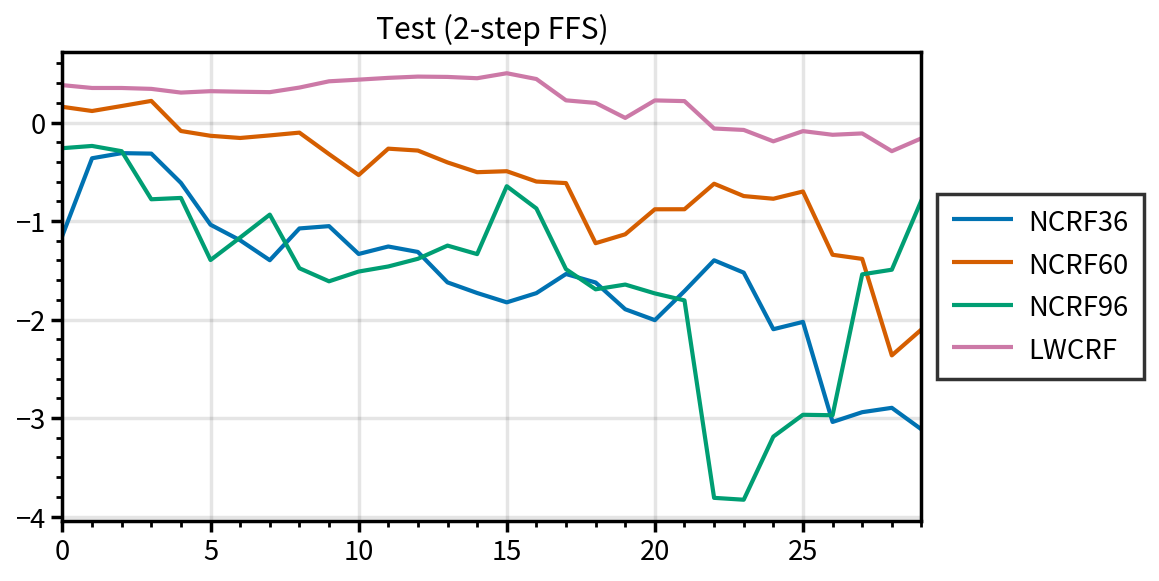

In [41]:
labels=['NCRF36','NCRF60','NCRF96','LWCRF']
fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(4):
    axs.plot(r2test[i],label=labels[i])
axs.legend(loc='r',ncols=1)
axs.format(title='Test (2-step FFS)')#,ylim=[-1,1])
plt.savefig('../../figures/0816/2stepFFS_maria_test.png',dpi=400)
plt.show()

In [44]:
[np.asarray(obj).argmax() for obj in r2test]

[2, 3, 1, 15]

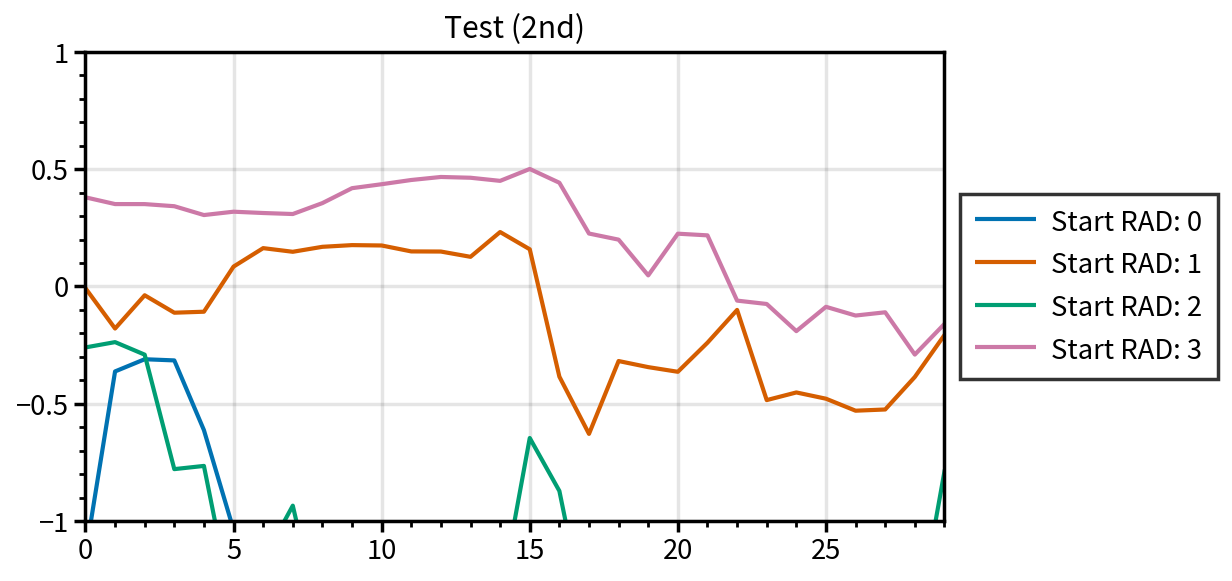

In [33]:
fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(4):
    axs.plot(r2test[i],label=f'Start RAD: {i}')
axs.legend(loc='r',ncols=1)
axs.format(title='Test (2nd)',ylim=[-1,1])
#plt.savefig('SFS1_valid_LWCRF.png',dpi=400)
plt.show()

In [25]:
(train_realUV[0])['du'].shape

(280, 7800)

#### Save

In [4]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/'
#read_and_proc.save_to_pickle(folderpath+'FFW/FFS_secondstep',FFS_secondstep,'PICKLE')
read_and_proc.save_to_pickle(folderpath+'FFW/FFS2step_compnum.pkl',[2, 3, 1, 15],'PICKLE')
#read_and_proc.save_to_pickle(folderpath+'FFW/model_24_4',FFSoutput['model'],'PICKLE')
#read_and_proc.save_to_pickle(folderpath+'FFW/reducedX_24_4',FFSoutput['reducedX'],'PICKLE')
#read_and_proc.save_to_pickle(folderpath+'FFW/newfeature_24_4',FFSoutput['newfeature'],'PICKLE')

In [13]:
! ls

Maria_FFS.ipynb  dask-worker-space	      preproc_3_Xy.ipynb
Trajs.ipynb	 preproc_1.smoothMARIA.ipynb
Untitled.ipynb	 preproc_2_outputPCA.ipynb


In [13]:
np.asarray([54,26,50,75,5,12,10]).cumsum()

array([ 54,  80, 130, 205, 210, 222, 232])

In [40]:
class FFS_analysis_plotting:
    def __init__(self,FFSoutput=None,PCAdict=None,case='Maria',TYPE='2D'):
        self.FFSoutput = FFSoutput
        self.PCAdict = PCAdict
        self.angle = read_and_proc.azimuth2angle(np.linspace(0,359,360))
        self.case=case
        self.TYPE=TYPE
        if self.case=='Maria' and self.TYPE=='2D':
            self.nrad=5
        elif self.case=='Maria' and self.TYPE=='3D':
            self.nrad=10
    
    def feature_importance_from_mlr(self,MODEL=None,smallX=None):
        def _get_feature_importance(WEIGHTx=None,smallXx=None):
            return np.nanmean(np.asarray([temp*smallXx for temp in WEIGHTx]),axis=1)
        weight = MODEL.coef_
        #WEIGHTZ = np.zeros_like(weight)
        return np.asarray([_get_feature_importance(weight[:,weightz],smallX[:,weightz]) for weightz in range(smallX.shape[1])])
    
    def flatten(self,xss): 
        return [x for xs in xss for x in xs]
    
    def out_anschoice(self,modelchoice=None,ind=None):
        return modelchoice[ind+1]
    
    def get_ans(self,modeliter=None):
        try:
            ans = [feature_importance_from_mlr(MODEL=self.FFSoutput['model'][modeliter][i],smallX=self.FFSoutput['reducedX'][modeliter][i]) for i in range(len(self.FFSoutput['model'][modeliter]))] #50 cross5, 
        except:
            ans = [feature_importance_from_mlr(MODEL=self.FFSoutput['model'][i],smallX=self.FFSoutput['reducedX'][i]) for i in range(len(self.FFSoutput['model']))]
        store = []
        for i in (range(self.nrad)):
            store.append([out_anschoice(ans[index],i+index).flatten() for index in range(len(ans))])    
        return [np.abs(flatten(store[i])) for i in range(self.nrad)]
    
    def plot_radKDE(self,featureimportance=None,cmap=plt.cm.tab10,suptitle='2D',xlim=[1,4],ylim=[0,0.3],saveloc='../../figures/0727/featureimportance_intermediate_maria_zoom.png'):
        colors = cmap(np.linspace(0,1,self.nrad))
        fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
        for i in range(self.nrad):
            sns.kdeplot(np.asarray(flatten([featureimportance[i]]))*1e4,color=colors[i],label=i+1)#,log_scale=True)#,cumulative=True)
        axs.legend(loc='ur',prop={'size':8},ncols=2,title='RAD PC#')
        axs[0].format(xlabel=r'Feature Importance (*$\mathit {10^4}$)',ylabel='Frequency',title='Radiative Heating PCs Feature Importance (*$\mathit {10^4}$)',xlim=xlim,ylim=ylim,suptitle=suptitle)#xlim=[0,0.0002*1.5e4])#ylim=[0,20])
        plt.savefig(saveloc,dpi=300)
        plt.show()
        return None
    
    def plot_eigen2d(self,toplotss=None,presaxis=None,subplotsetting=[3,2,4.295,1.731],contourlevel=np.linspace(-0.03,0.03,21),RAD=True,titles=None,suptitle='Maria 2D',axesDELETE=5,saveloc='../../figures/0727/maria2D_RAD.png'):
        fig,axs = plot.subplots(ncols=subplotsetting[0],nrows=subplotsetting[1],axwidth=subplotsetting[2],refaspect=subplotsetting[3])
        for inx,i in enumerate(toplotss):
            pcw=axs[inx].contourf(np.linspace(0,199,200)*3,presaxis,toplotss[inx].reshape(39,200),cmap='balance',levels=np.linspace(-0.03,0.03,21),extend='both')
            axs[inx].colorbar(pcw,loc='ur',ticks=contourlevel[-1])
            if RAD is True:
                axs[inx].format(title=f'RAD PC#{str(inx+1)}')
            else:
                axs[inx].format(title=titles[inx])       
        axs.format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',suptitle=suptitle)
        axs[int(axesDELETE)].set_visible(False)
        plt.savefig(saveloc,dpi=300,facecolor='w')
        plt.show()
        return None

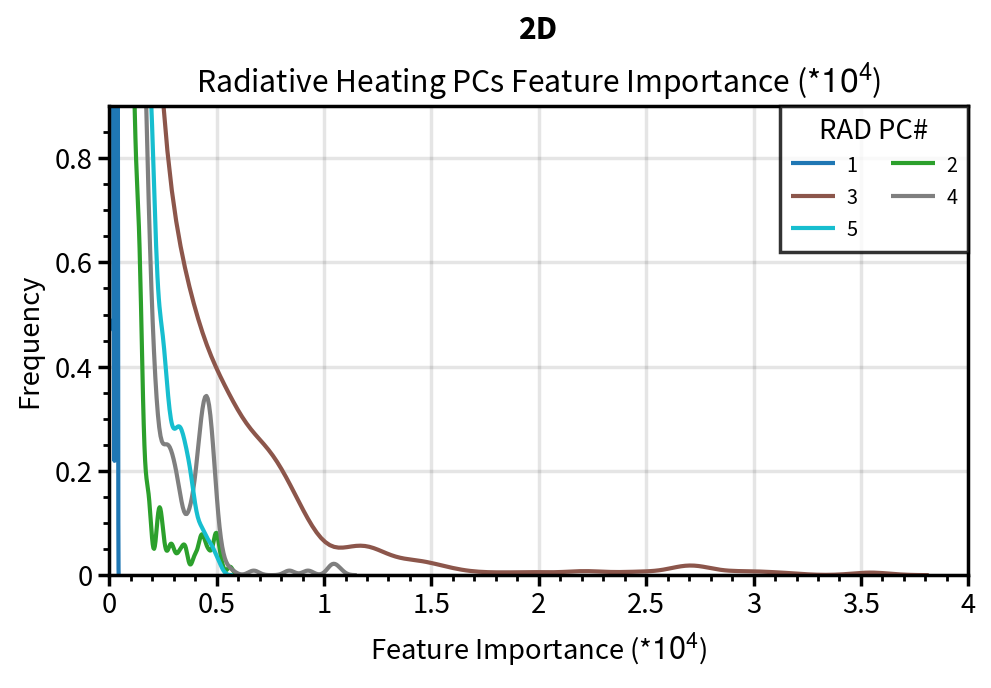

In [27]:
#allans = [get_ans(i) for i in tqdm(range(len(model_FFW)))]
allans = FFS_analysis_plotting(FFSoutput,dict1,'Maria','2D').get_ans(0)
azimplotKDE = FFS_analysis_plotting(FFSoutput,dict1,'Maria','2D').plot_radKDE(featureimportance=allans,cmap=plt.cm.tab10,suptitle='2D',xlim=[0,4],ylim=[0,0.9],saveloc='../../figures/0727/featureimportance_intermediate_maria_zoom.png')

#### Important features

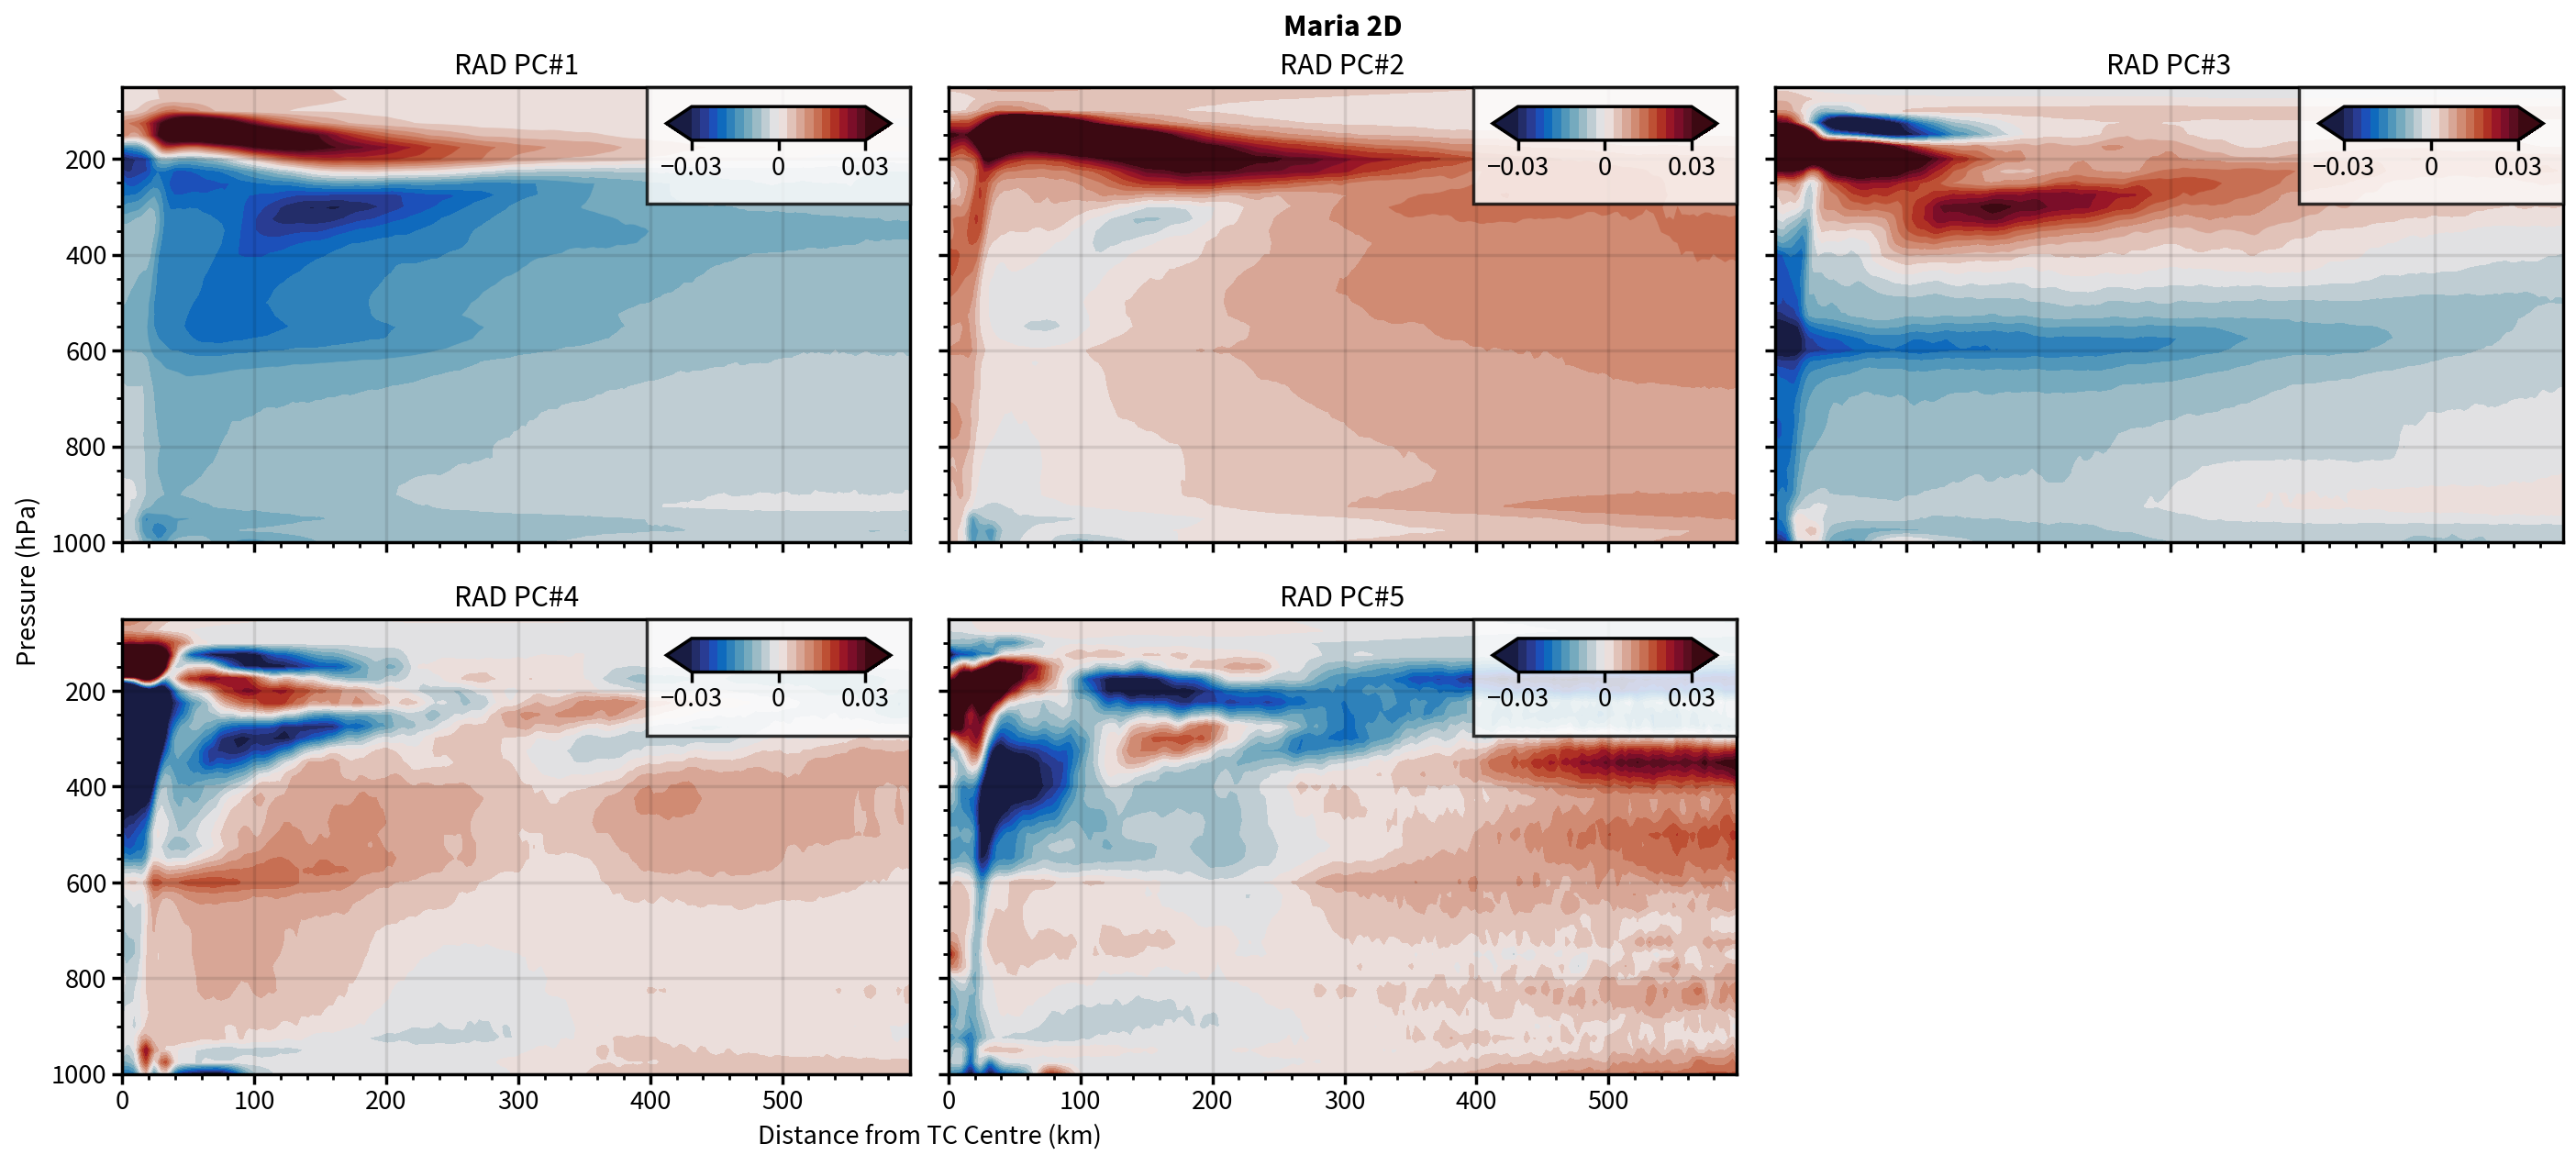

In [41]:
aaaa = xr.open_dataset('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/data/maria/U.nc')
toplots = [dict1['rad'].components_[i,:] for i in range(5)]
FFS_analysis_plotting(FFSoutput,dict1,'Maria','2D').plot_eigen2d(toplotss=toplots,presaxis=aaaa.pres.data,subplotsetting=[3,2,4.295,1.731],contourlevel=np.linspace(-0.03,0.03,21),RAD=True,titles=None,suptitle='Maria 2D',axesDELETE=5,saveloc='../../figures/0727/maria2D_RAD.png')

In [42]:
import pandas as pd
TYPE='Maria_2D'
if TYPE=='Maria_2D': indexcumsum = np.asarray([20,11,20,12,5,7,5]).cumsum()
elif TYPE=='Haiyan_2D': indexcumsum = np.asarray([20,11,20,14,9,6,4]).cumsum()
print(indexcumsum)
#alllist = (flatten([new_feature_c3[i][0:5] for i in range(len(model_c3))])+flatten([new_feature_c32[i][0:5] for i in range(len(model_c32))]))
#a = pd.Series(alllist).value_counts()

[20 31 51 63 68 75 80]


In [46]:
#alllist = (flatten([new_feature_c3[i][0:5] for i in range(len(model_c3))])+flatten([new_feature_c32[i][0:5] for i in range(len(model_c32))]))
alllist = FFSoutput['newfeature'][0:5]
pd.Series(alllist)#.value_counts()

0    39
1    74
2     2
3    14
4    13
dtype: int64

#### 3D

/tmp/ipykernel_1581228/4034426045.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


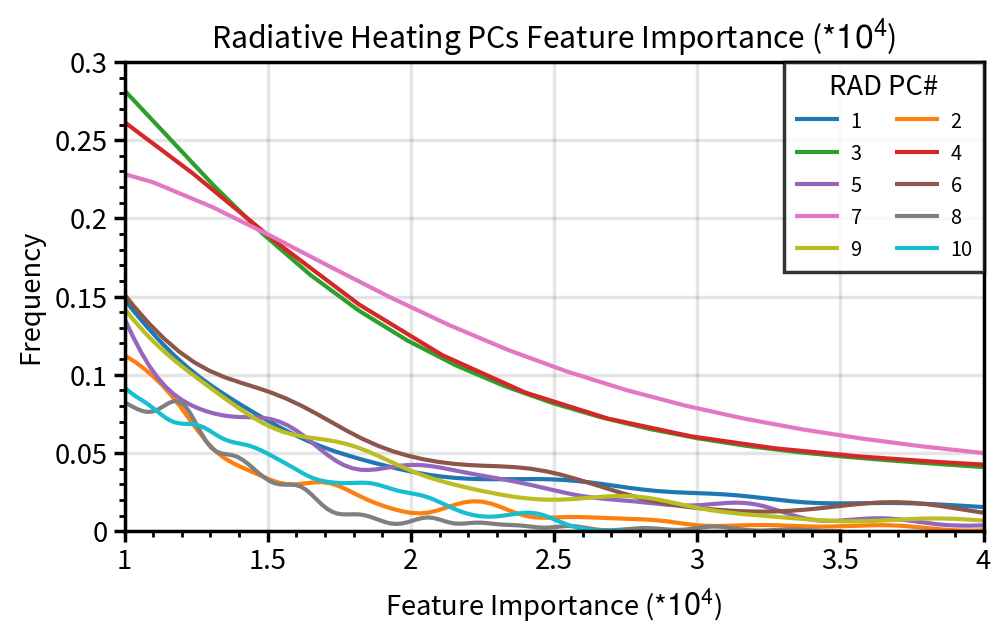

In [22]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

import matplotlib.pyplot as plt
colors=plt.cm.tab10(np.linspace(0, 1, 10))
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(10):
    sns.kdeplot(np.asarray(flatten([allans[i]]))*1e4,color=colors[i],label=i+1)#,log_scale=True)#,cumulative=True)
axs.legend(loc='ur',prop={'size':8},ncols=2,title='RAD PC#')
axs[0].format(xlabel=r'Feature Importance (*$\mathit {10^4}$)',ylabel='Frequency',title='Radiative Heating PCs Feature Importance (*$\mathit {10^4}$)',xlim=[1,4],ylim=[0,0.3],suptitle=suptitle)#xlim=[0,0.0002*1.5e4])#ylim=[0,20])
plt.savefig('../../figures/0727/featureimportance_intermediate_maria_zoom.png',dpi=300)
plt.show()

In [23]:
aaaa = xr.open_dataset('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/data/maria/U.nc')
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,199,200)*3),np.linspace(0,199,200)*3))
np.fliplr(np.flipud((read_and_proc.proc_tocart(dict1['rad'].components_[6,...].reshape(39,360,200)[8,...],ANGLE,True,False)))).shape

(400, 400)

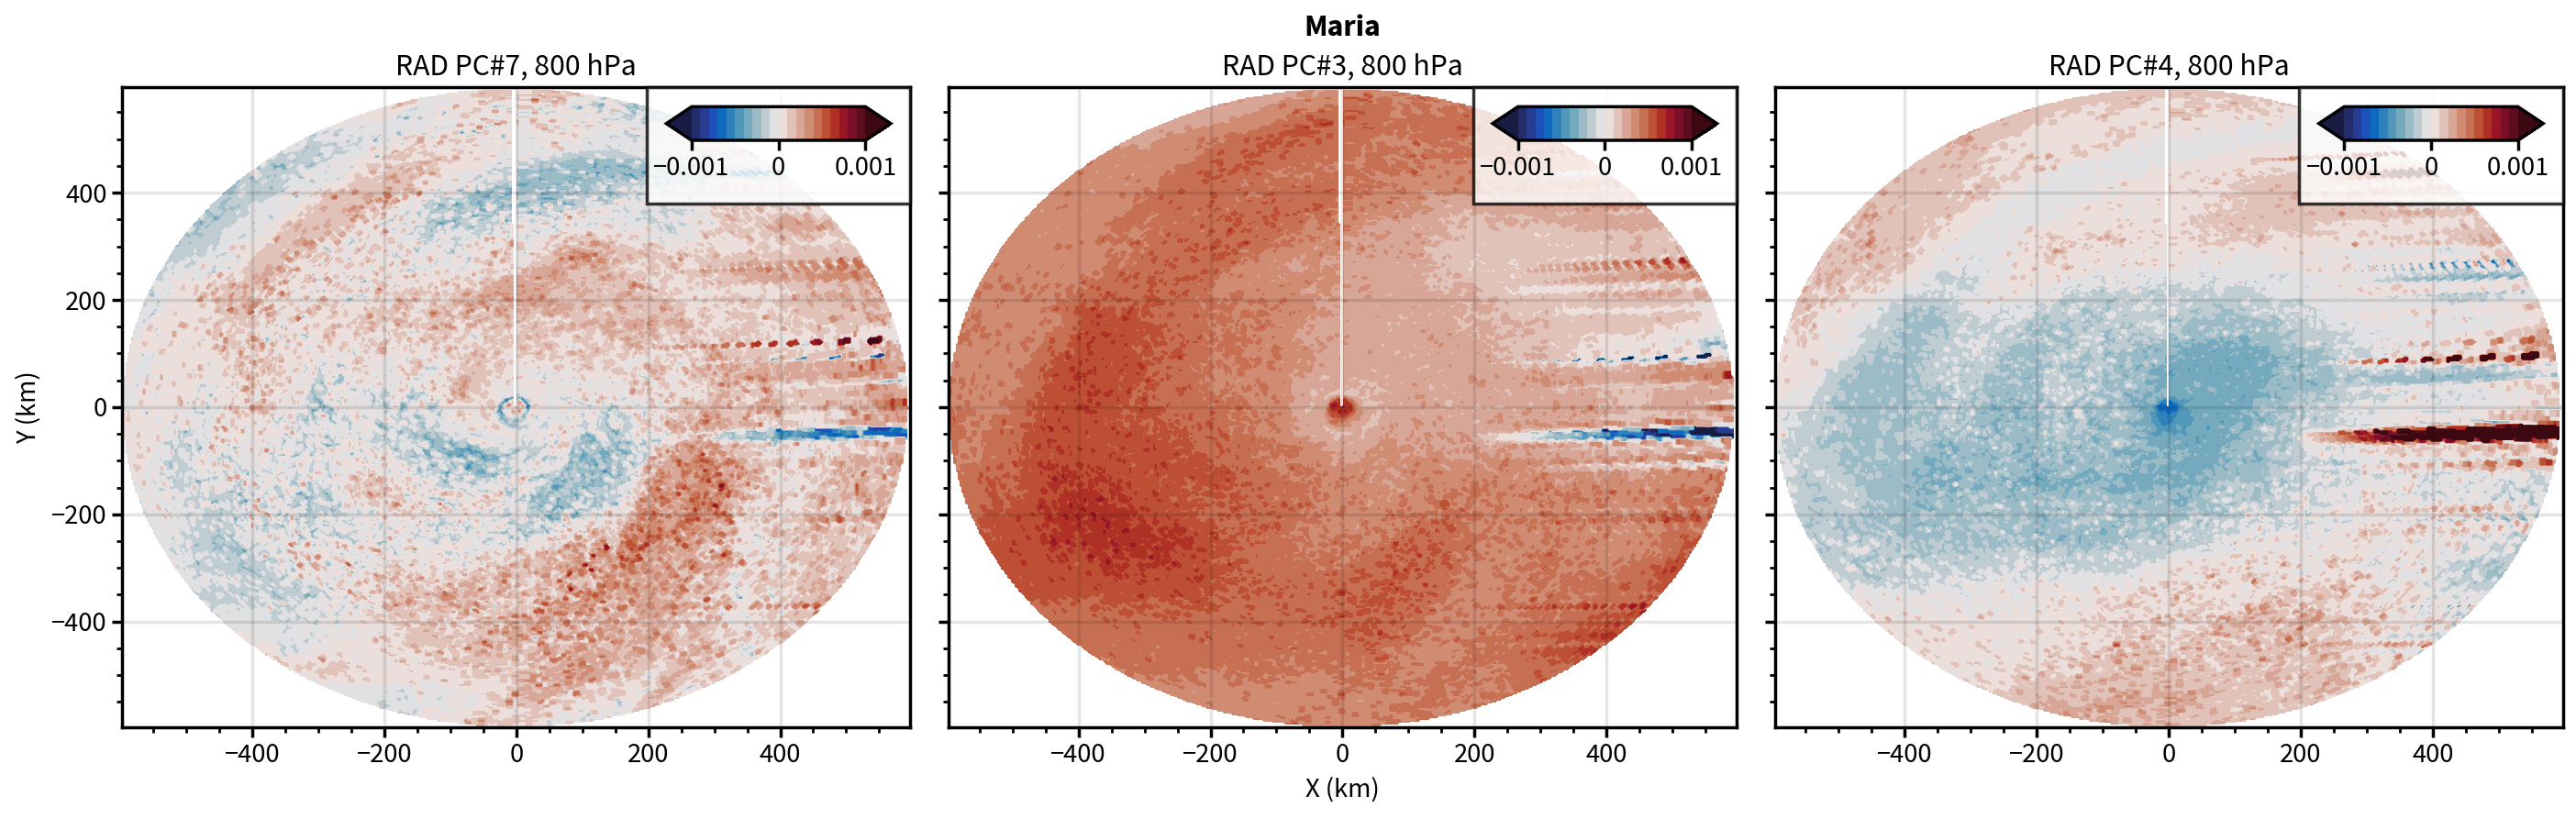

In [82]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,199,200)*3),np.linspace(0,199,200)*3))
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.231)
for inx,i in enumerate([6,2,3]):
    pcw=axs[inx].contourf(np.linspace(-199,199,400)*3,np.linspace(-199,199,400)*3,
                   np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(dict1['rad'].components_[i,...].reshape(39,360,200)[8,...],ANGLE,True,False)))),0),cmap='balance',levels=np.linspace(-0.0010,0.0010,21),extend='both')
    axs[inx].colorbar(pcw,loc='ur',ticks=0.001)
    axs[inx].format(title=f'RAD PC#{str(i+1)}, 800 hPa')
axs.format(xlabel=r'X (km)',ylabel='Y (km)',suptitle='Maria')
plt.savefig('../../figures/0727/maria_important_RAD.png',dpi=300)
plt.show()

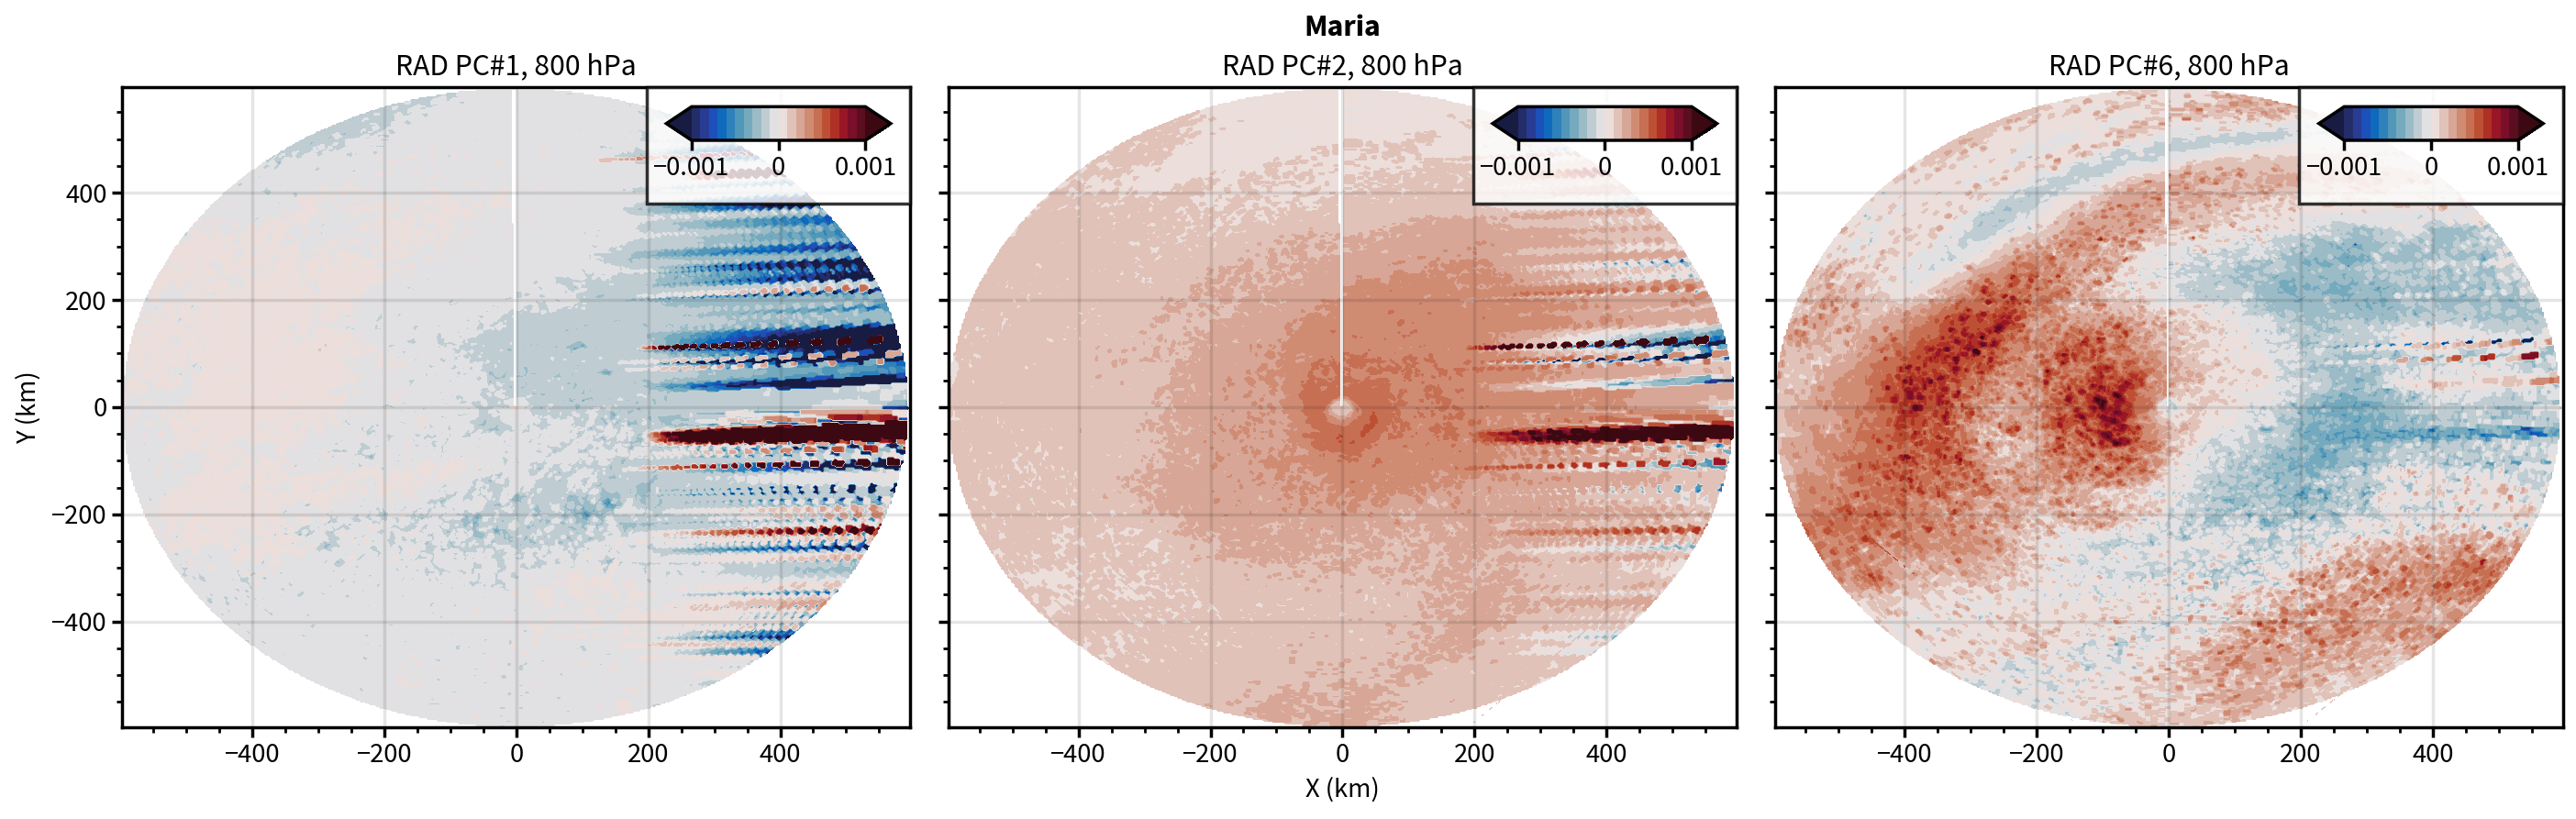

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [83]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,199,200)*3),np.linspace(0,199,200)*3))
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.231)
for inx,i in enumerate([0,1,5]):
    pcw=axs[inx].contourf(np.linspace(-199,199,400)*3,np.linspace(-199,199,400)*3,
                   np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(dict1['rad'].components_[i,...].reshape(39,360,200)[8,...],ANGLE,True,False)))),0),cmap='balance',levels=np.linspace(-0.0010,0.0010,21),extend='both')
    axs[inx].colorbar(pcw,loc='ur',ticks=0.001)
    axs[inx].format(title=f'RAD PC#{str(i+1)}, 800 hPa')
axs.format(xlabel=r'X (km)',ylabel='Y (km)',suptitle='Maria')
plt.savefig('../../figures/0727/maria_unimportant_RAD.png',dpi=300)
plt.show()

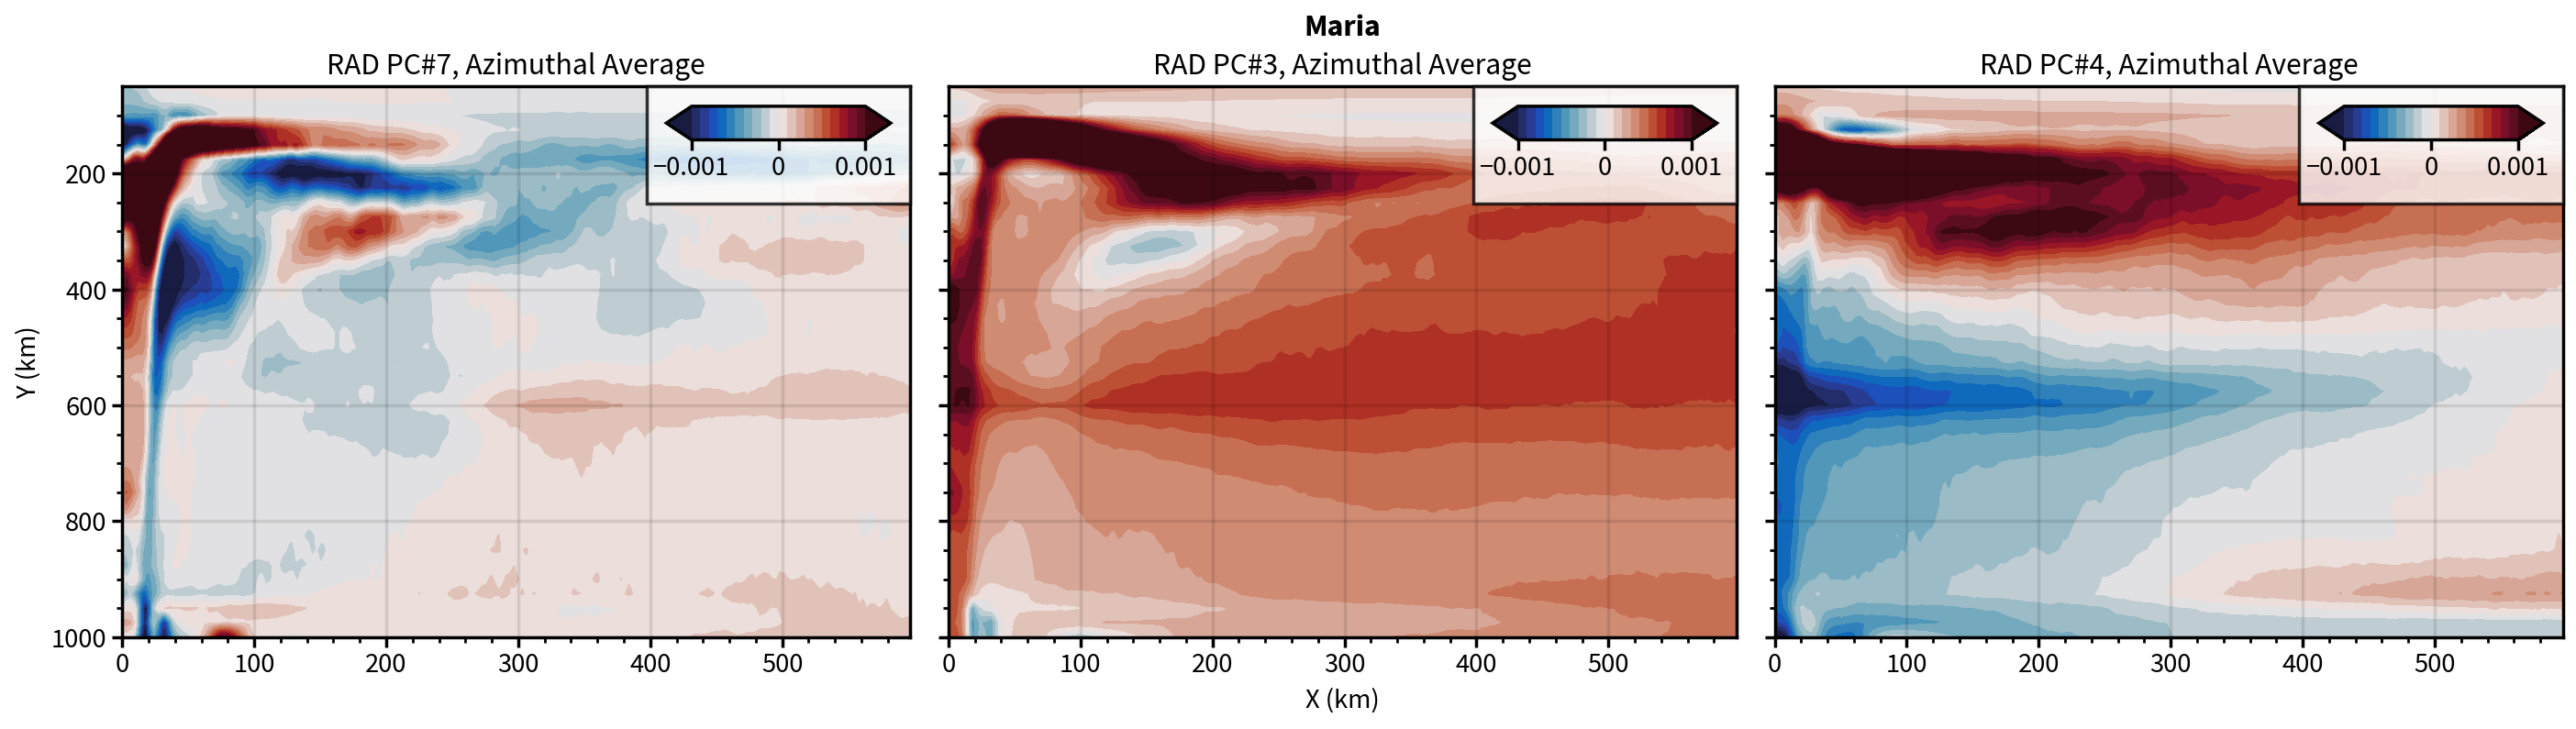

In [26]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.431)
for inx,i in enumerate([6,2,3]):
    pcw=axs[inx].contourf(np.linspace(0,199,200)*3,aaaa.pres.data,
                   np.nanmean(dict1['rad'].components_[i,...].reshape(39,360,200),axis=1),cmap='balance',levels=np.linspace(-0.0010,0.0010,21),extend='both')
    axs[inx].colorbar(pcw,loc='ur',ticks=0.001)
    axs[inx].format(title=f'RAD PC#{str(i+1)}, Azimuthal Average')
axs.format(xlabel=r'X (km)',ylabel='Y (km)',suptitle='Maria')
plt.savefig('../../figures/0727/maria_important_RAD_azimavg.png',dpi=300)
plt.show()